# A Gentle Introduction to Transfer Learning

In [1]:
import sys
import os
import numpy as np
import pandas as pd
from collections import Counter
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler, SGD
from torch.autograd import Variable
from torchvision import models
from utils import (get_gpu_name, get_number_processors, plot_pytorch_data_stream, train_model, create_dataset, 
                   available_models, plot_metrics)

print("OS: ", sys.platform)
print("Python: ", sys.version)
print("PyTorch: ", torch.__version__)
print("Numpy: ", np.__version__)
print("Number of CPU processors: ", get_number_processors())
print("GPU: ", get_gpu_name())

%matplotlib inline
%load_ext autoreload
%autoreload 2

OS:  linux
Python:  3.5.4 | packaged by conda-forge | (default, Nov  4 2017, 10:11:29) 
[GCC 4.8.2 20140120 (Red Hat 4.8.2-15)]
PyTorch:  0.2.0_3
Numpy:  1.13.3
Number of CPU processors:  24
GPU:  ['Tesla M60', 'Tesla M60', 'Tesla M60', 'Tesla M60']


In [2]:
torch.backends.cudnn.benchmark=True # enables cudnn's auto-tuner

In [3]:
MODEL_NAME = 'resnet18'
BATCH_SIZE = 64
SETS = ['train', 'val']
NUM_GPUS = 4
EPOCHS = 20
LR = 0.001
LR_STEP = 0.1
LR_EPOCHS = 7
MOMENTUM = 0.9

## Model and utilities

In [4]:
model_names = available_models()
print(model_names)

['alexnet', 'densenet121', 'densenet161', 'densenet169', 'densenet201', 'inception_v3', 'resnet101', 'resnet152', 'resnet18', 'resnet34', 'resnet50', 'squeezenet1_0', 'squeezenet1_1', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19', 'vgg19_bn']


In [5]:
def finetune(dataloaders, model_name, sets, num_epochs, num_gpus, lr, momentum, lr_step, lr_epochs, verbose=True):
    #Class adaptation
    num_class = len(dataloaders[sets[0]].dataset.class_to_idx)
    model_ft = models.__dict__[model_name](pretrained=True)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, num_class)
    
    #gpus
    if num_gpus > 1: 
        model_ft = nn.DataParallel(model_ft)
    model_ft = model_ft.cuda()
    
    #loss
    criterion = nn.CrossEntropyLoss()

    # All parameters are being optimized
    optimizer = SGD(model_ft.parameters(), lr=lr, momentum=momentum)

    # Decay LR by a factor of lr_step every lr_epochs epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=lr_epochs, gamma=lr_step)
    model_ft = train_model(dataloaders, model_ft, sets, criterion, optimizer, exp_lr_scheduler, 
                           num_epochs=num_epochs, verbose=verbose)
    return model_ft

In [6]:
def freeze_and_train(dataloaders, model_name, sets, num_epochs, num_gpus, lr, momentum, lr_step, lr_epochs, verbose=True):
    #Class adaptation
    num_class = len(dataloaders[sets[0]].dataset.class_to_idx)
    model_conv = models.__dict__[model_name](pretrained=True)
    for param in model_conv.parameters(): #params have requires_grad=True by default
        param.requires_grad = False
    num_ftrs = model_conv.fc.in_features
    model_conv.fc = nn.Linear(num_ftrs, num_class)
    
    #gpus
    if num_gpus > 1: 
        model_conv = nn.DataParallel(model_conv)
    model_conv = model_conv.cuda()
    
    #loss
    criterion = nn.CrossEntropyLoss()

    # Only parameters of final layer are being optimized 
    if num_gpus > 1:
        params = model_conv.module.fc.parameters()
    else:
        params = model_conv.fc.parameters()
    optimizer = SGD(params, lr=lr, momentum=momentum)

    # Decay LR by a factor of lr_step every lr_epochs epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=lr_epochs, gamma=lr_step)
    model_conv = train_model(dataloaders, model_conv, sets, criterion, optimizer, exp_lr_scheduler, 
                             num_epochs=num_epochs, verbose=verbose)
    return model_conv

## Datasets
We are going to use the dataset [hymenoptera](https://download.pytorch.org/tutorial/hymenoptera_data.zip)

In [7]:
DATA_ROOT = '/datadrive'

HYMENOPTERA_ROOT = os.path.join(DATA_ROOT, 'hymenoptera_data')
HYMENOPTERA_GRAY_ROOT = os.path.join(DATA_ROOT, 'hymenoptera_gray')

SIMPSONS_ROOT = os.path.join(DATA_ROOT, 'simpsons', 'simpsons')
SIMPSONS_GRAY_ROOT = os.path.join(DATA_ROOT, 'simpsons', 'simpsons_gray')

DOGS_CATS_ROOT = os.path.join(DATA_ROOT, 'dogs_vs_cats', 'dogs_vs_cats')
DOGS_CATS_GRAY_ROOT = os.path.join(DATA_ROOT, 'dogs_vs_cats', 'dogs_vs_cats_gray')

CALTECH256_ROOT = os.path.join(DATA_ROOT, 'caltech256','caltech256')
CALTECH256_GRAY_ROOT = os.path.join(DATA_ROOT, 'caltech256','caltech256')

In [8]:
data_hymenoptera = create_dataset(HYMENOPTERA_ROOT, batch_size=BATCH_SIZE)

There are 2 clases in the dataset: {
    "ants": 0,
    "bees": 1
}
Sets sizes:  {
    "train": 244,
    "val": 153
}
Number of items in set train: {0: 123, 1: 121}
Number of items in set val: {0: 70, 1: 83}


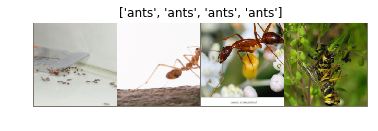

In [9]:
plot_pytorch_data_stream(data_hymenoptera['train'], max_images=4)

In [10]:
data_hymenoptera_gray = create_dataset(HYMENOPTERA_GRAY_ROOT, batch_size=BATCH_SIZE)

There are 2 clases in the dataset: {
    "ants": 0,
    "bees": 1
}
Sets sizes:  {
    "train": 244,
    "val": 153
}
Number of items in set train: {0: 123, 1: 121}
Number of items in set val: {0: 70, 1: 83}


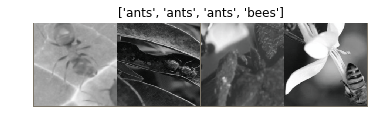

In [11]:
plot_pytorch_data_stream(data_hymenoptera_gray['train'], max_images=4)

In [12]:
data_simpsons = create_dataset(SIMPSONS_ROOT, batch_size=BATCH_SIZE*NUM_GPUS)

There are 20 clases in the dataset: {
    "abraham_grampa_simpson": 0,
    "apu_nahasapeemapetilon": 1,
    "bart_simpson": 2,
    "charles_montgomery_burns": 3,
    "chief_wiggum": 4,
    "comic_book_guy": 5,
    "edna_krabappel": 6,
    "homer_simpson": 7,
    "kent_brockman": 8,
    "krusty_the_clown": 9,
    "lenny_leonard": 10,
    "lisa_simpson": 11,
    "marge_simpson": 12,
    "mayor_quimby": 13,
    "milhouse_van_houten": 14,
    "moe_szyslak": 15,
    "ned_flanders": 16,
    "nelson_muntz": 17,
    "principal_skinner": 18,
    "sideshow_bob": 19
}
Sets sizes:  {
    "train": 15638,
    "val": 3910
}
Number of items in set train: {0: 730, 1: 498, 2: 1074, 3: 954, 4: 789, 5: 375, 6: 366, 7: 1797, 8: 398, 9: 965, 10: 248, 11: 1083, 12: 1033, 13: 197, 14: 863, 15: 1162, 16: 1163, 17: 286, 18: 955, 19: 702}
Number of items in set val: {0: 183, 1: 125, 2: 268, 3: 239, 4: 197, 5: 94, 6: 91, 7: 449, 8: 100, 9: 241, 10: 62, 11: 271, 12: 258, 13: 49, 14: 216, 15: 290, 16: 291, 17: 72, 

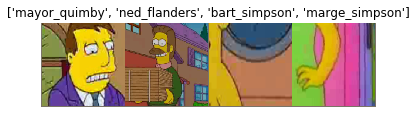

In [13]:
plot_pytorch_data_stream(data_simpsons['train'], max_images=4)

In [14]:
data_simpsons_gray = create_dataset(SIMPSONS_GRAY_ROOT, batch_size=BATCH_SIZE*NUM_GPUS)

There are 20 clases in the dataset: {
    "abraham_grampa_simpson": 0,
    "apu_nahasapeemapetilon": 1,
    "bart_simpson": 2,
    "charles_montgomery_burns": 3,
    "chief_wiggum": 4,
    "comic_book_guy": 5,
    "edna_krabappel": 6,
    "homer_simpson": 7,
    "kent_brockman": 8,
    "krusty_the_clown": 9,
    "lenny_leonard": 10,
    "lisa_simpson": 11,
    "marge_simpson": 12,
    "mayor_quimby": 13,
    "milhouse_van_houten": 14,
    "moe_szyslak": 15,
    "ned_flanders": 16,
    "nelson_muntz": 17,
    "principal_skinner": 18,
    "sideshow_bob": 19
}
Sets sizes:  {
    "train": 15638,
    "val": 3910
}
Number of items in set train: {0: 730, 1: 498, 2: 1074, 3: 954, 4: 789, 5: 375, 6: 366, 7: 1797, 8: 398, 9: 965, 10: 248, 11: 1083, 12: 1033, 13: 197, 14: 863, 15: 1162, 16: 1163, 17: 286, 18: 955, 19: 702}
Number of items in set val: {0: 183, 1: 125, 2: 268, 3: 239, 4: 197, 5: 94, 6: 91, 7: 449, 8: 100, 9: 241, 10: 62, 11: 271, 12: 258, 13: 49, 14: 216, 15: 290, 16: 291, 17: 72, 

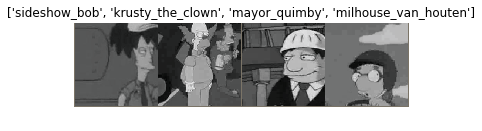

In [15]:
plot_pytorch_data_stream(data_simpsons_gray['train'], max_images=4)

In [16]:
data_dogs_vs_cats = create_dataset(DOGS_CATS_ROOT, batch_size=BATCH_SIZE*NUM_GPUS)

There are 2 clases in the dataset: {
    "cats": 0,
    "dogs": 1
}
Sets sizes:  {
    "train": 20000,
    "val": 5000
}
Number of items in set train: {0: 10000, 1: 10000}
Number of items in set val: {0: 2500, 1: 2500}


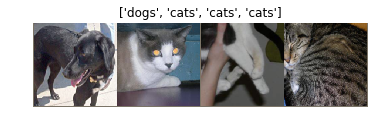

In [17]:
plot_pytorch_data_stream(data_dogs_vs_cats['train'], max_images=4)

In [18]:
data_dogs_vs_cats_gray = create_dataset(DOGS_CATS_GRAY_ROOT, batch_size=BATCH_SIZE*NUM_GPUS)

There are 2 clases in the dataset: {
    "cats": 0,
    "dogs": 1
}
Sets sizes:  {
    "train": 20000,
    "val": 5000
}
Number of items in set train: {0: 10000, 1: 10000}
Number of items in set val: {0: 2500, 1: 2500}


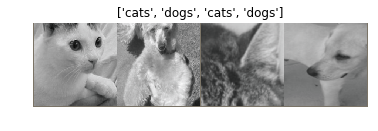

In [19]:
plot_pytorch_data_stream(data_dogs_vs_cats_gray['train'], max_images=4)

In [20]:
data_caltech256 = create_dataset(CALTECH256_ROOT, batch_size=BATCH_SIZE*NUM_GPUS)

There are 257 clases in the dataset: {
    "001.ak47": 0,
    "002.american-flag": 1,
    "003.backpack": 2,
    "004.baseball-bat": 3,
    "005.baseball-glove": 4,
    "006.basketball-hoop": 5,
    "007.bat": 6,
    "008.bathtub": 7,
    "009.bear": 8,
    "010.beer-mug": 9,
    "011.billiards": 10,
    "012.binoculars": 11,
    "013.birdbath": 12,
    "014.blimp": 13,
    "015.bonsai-101": 14,
    "016.boom-box": 15,
    "017.bowling-ball": 16,
    "018.bowling-pin": 17,
    "019.boxing-glove": 18,
    "020.brain-101": 19,
    "021.breadmaker": 20,
    "022.buddha-101": 21,
    "023.bulldozer": 22,
    "024.butterfly": 23,
    "025.cactus": 24,
    "026.cake": 25,
    "027.calculator": 26,
    "028.camel": 27,
    "029.cannon": 28,
    "030.canoe": 29,
    "031.car-tire": 30,
    "032.cartman": 31,
    "033.cd": 32,
    "034.centipede": 33,
    "035.cereal-box": 34,
    "036.chandelier-101": 35,
    "037.chess-board": 36,
    "038.chimp": 37,
    "039.chopsticks": 38,
    "040.cockro

Number of items in set val: {0: 20, 1: 19, 2: 30, 3: 25, 4: 30, 5: 18, 6: 21, 7: 46, 8: 20, 9: 19, 10: 56, 11: 43, 12: 20, 13: 17, 14: 24, 15: 18, 16: 21, 17: 20, 18: 25, 19: 17, 20: 28, 21: 19, 22: 22, 23: 22, 24: 23, 25: 21, 26: 20, 27: 22, 28: 21, 29: 21, 30: 18, 31: 20, 32: 20, 33: 20, 34: 17, 35: 21, 36: 24, 37: 22, 38: 17, 39: 25, 40: 17, 41: 17, 42: 25, 43: 24, 44: 17, 45: 27, 46: 19, 47: 21, 48: 21, 49: 19, 50: 23, 51: 17, 52: 16, 53: 24, 54: 20, 55: 20, 56: 21, 57: 19, 58: 17, 59: 17, 60: 20, 61: 17, 62: 24, 63: 26, 64: 20, 65: 17, 66: 17, 67: 22, 68: 20, 69: 17, 70: 20, 71: 24, 72: 20, 73: 23, 74: 17, 75: 17, 76: 18, 77: 18, 78: 20, 79: 23, 80: 19, 81: 16, 82: 19, 83: 17, 84: 22, 85: 16, 86: 19, 87: 20, 88: 22, 89: 42, 90: 19, 91: 40, 92: 22, 93: 21, 94: 17, 95: 57, 96: 18, 97: 20, 98: 16, 99: 19, 100: 28, 101: 18, 102: 22, 103: 19, 104: 54, 105: 17, 106: 18, 107: 17, 108: 31, 109: 17, 110: 17, 111: 17, 112: 23, 113: 24, 114: 18, 115: 21, 116: 24, 117: 22, 118: 17, 119: 26, 1

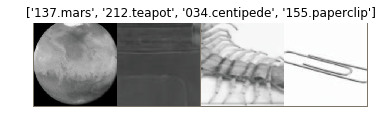

In [21]:
plot_pytorch_data_stream(data_caltech256['train'], max_images=4)

In [22]:
data_caltech256_gray = create_dataset(CALTECH256_GRAY_ROOT, batch_size=BATCH_SIZE*NUM_GPUS)

There are 257 clases in the dataset: {
    "001.ak47": 0,
    "002.american-flag": 1,
    "003.backpack": 2,
    "004.baseball-bat": 3,
    "005.baseball-glove": 4,
    "006.basketball-hoop": 5,
    "007.bat": 6,
    "008.bathtub": 7,
    "009.bear": 8,
    "010.beer-mug": 9,
    "011.billiards": 10,
    "012.binoculars": 11,
    "013.birdbath": 12,
    "014.blimp": 13,
    "015.bonsai-101": 14,
    "016.boom-box": 15,
    "017.bowling-ball": 16,
    "018.bowling-pin": 17,
    "019.boxing-glove": 18,
    "020.brain-101": 19,
    "021.breadmaker": 20,
    "022.buddha-101": 21,
    "023.bulldozer": 22,
    "024.butterfly": 23,
    "025.cactus": 24,
    "026.cake": 25,
    "027.calculator": 26,
    "028.camel": 27,
    "029.cannon": 28,
    "030.canoe": 29,
    "031.car-tire": 30,
    "032.cartman": 31,
    "033.cd": 32,
    "034.centipede": 33,
    "035.cereal-box": 34,
    "036.chandelier-101": 35,
    "037.chess-board": 36,
    "038.chimp": 37,
    "039.chopsticks": 38,
    "040.cockro

Number of items in set val: {0: 20, 1: 19, 2: 30, 3: 25, 4: 30, 5: 18, 6: 21, 7: 46, 8: 20, 9: 19, 10: 56, 11: 43, 12: 20, 13: 17, 14: 24, 15: 18, 16: 21, 17: 20, 18: 25, 19: 17, 20: 28, 21: 19, 22: 22, 23: 22, 24: 23, 25: 21, 26: 20, 27: 22, 28: 21, 29: 21, 30: 18, 31: 20, 32: 20, 33: 20, 34: 17, 35: 21, 36: 24, 37: 22, 38: 17, 39: 25, 40: 17, 41: 17, 42: 25, 43: 24, 44: 17, 45: 27, 46: 19, 47: 21, 48: 21, 49: 19, 50: 23, 51: 17, 52: 16, 53: 24, 54: 20, 55: 20, 56: 21, 57: 19, 58: 17, 59: 17, 60: 20, 61: 17, 62: 24, 63: 26, 64: 20, 65: 17, 66: 17, 67: 22, 68: 20, 69: 17, 70: 20, 71: 24, 72: 20, 73: 23, 74: 17, 75: 17, 76: 18, 77: 18, 78: 20, 79: 23, 80: 19, 81: 16, 82: 19, 83: 17, 84: 22, 85: 16, 86: 19, 87: 20, 88: 22, 89: 42, 90: 19, 91: 40, 92: 22, 93: 21, 94: 17, 95: 57, 96: 18, 97: 20, 98: 16, 99: 19, 100: 28, 101: 18, 102: 22, 103: 19, 104: 54, 105: 17, 106: 18, 107: 17, 108: 31, 109: 17, 110: 17, 111: 17, 112: 23, 113: 24, 114: 18, 115: 21, 116: 24, 117: 22, 118: 17, 119: 26, 1

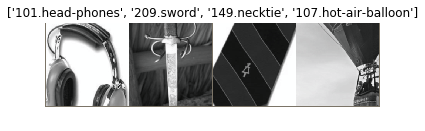

In [23]:
plot_pytorch_data_stream(data_caltech256_gray['train'], max_images=4)

## Training

In [24]:
val_acc = 'Validation accuracy'
df = pd.DataFrame(columns=[val_acc])


In [25]:
model, metrics = finetune(data_hymenoptera, MODEL_NAME, SETS, EPOCHS, 1, LR, 
                          MOMENTUM, LR_STEP, LR_EPOCHS)


Epoch 1/20
----------
train Loss: 0.0136 Acc: 0.5246
val Loss: 0.0113 Acc: 0.6993

Epoch 2/20
----------
train Loss: 0.0106 Acc: 0.5861
val Loss: 0.0113 Acc: 0.6732

Epoch 3/20
----------
train Loss: 0.0084 Acc: 0.7295
val Loss: 0.0070 Acc: 0.8889

Epoch 4/20
----------
train Loss: 0.0065 Acc: 0.8566
val Loss: 0.0061 Acc: 0.9020

Epoch 5/20
----------
train Loss: 0.0056 Acc: 0.8648
val Loss: 0.0044 Acc: 0.9216

Epoch 6/20
----------
train Loss: 0.0044 Acc: 0.9057
val Loss: 0.0048 Acc: 0.9281

Epoch 7/20
----------
train Loss: 0.0040 Acc: 0.9139
val Loss: 0.0042 Acc: 0.9281

Epoch 8/20
----------
train Loss: 0.0034 Acc: 0.9385
val Loss: 0.0039 Acc: 0.9281

Epoch 9/20
----------
train Loss: 0.0033 Acc: 0.9508
val Loss: 0.0049 Acc: 0.9216

Epoch 10/20
----------
train Loss: 0.0035 Acc: 0.9344
val Loss: 0.0036 Acc: 0.9216

Epoch 11/20
----------
train Loss: 0.0034 Acc: 0.9303
val Loss: 0.0036 Acc: 0.9216

Epoch 12/20
----------
train Loss: 0.0034 Acc: 0.9344
val Loss: 0.0037 Acc: 0.9216



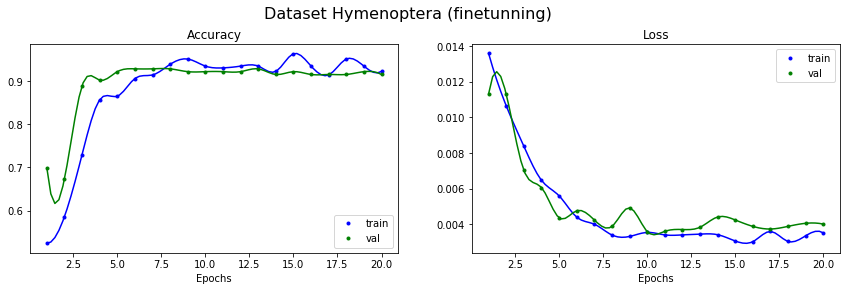

In [26]:
dataset_name = "Dataset Hymenoptera (finetuning)"
plot_metrics(metrics, dataset_name)
df.at[dataset_name, val_acc] = max(metrics['val_acc'])

In [27]:
model, metrics = freeze_and_train(data_hymenoptera, MODEL_NAME, SETS, EPOCHS, 1, LR, 
                                  MOMENTUM, LR_STEP, LR_EPOCHS)


Epoch 1/20
----------
train Loss: 0.0123 Acc: 0.4918
val Loss: 0.0114 Acc: 0.7190

Epoch 2/20
----------
train Loss: 0.0113 Acc: 0.5533
val Loss: 0.0110 Acc: 0.7516

Epoch 3/20
----------
train Loss: 0.0093 Acc: 0.7049
val Loss: 0.0094 Acc: 0.7974

Epoch 4/20
----------
train Loss: 0.0085 Acc: 0.7418
val Loss: 0.0080 Acc: 0.8497

Epoch 5/20
----------
train Loss: 0.0068 Acc: 0.8443
val Loss: 0.0066 Acc: 0.9412

Epoch 6/20
----------
train Loss: 0.0064 Acc: 0.8730
val Loss: 0.0055 Acc: 0.9281

Epoch 7/20
----------
train Loss: 0.0054 Acc: 0.8975
val Loss: 0.0053 Acc: 0.9216

Epoch 8/20
----------
train Loss: 0.0048 Acc: 0.9098
val Loss: 0.0052 Acc: 0.9216

Epoch 9/20
----------
train Loss: 0.0051 Acc: 0.8975
val Loss: 0.0055 Acc: 0.9216

Epoch 10/20
----------
train Loss: 0.0047 Acc: 0.9262
val Loss: 0.0052 Acc: 0.9281

Epoch 11/20
----------
train Loss: 0.0051 Acc: 0.8975
val Loss: 0.0057 Acc: 0.9281

Epoch 12/20
----------
train Loss: 0.0053 Acc: 0.9016
val Loss: 0.0052 Acc: 0.9281



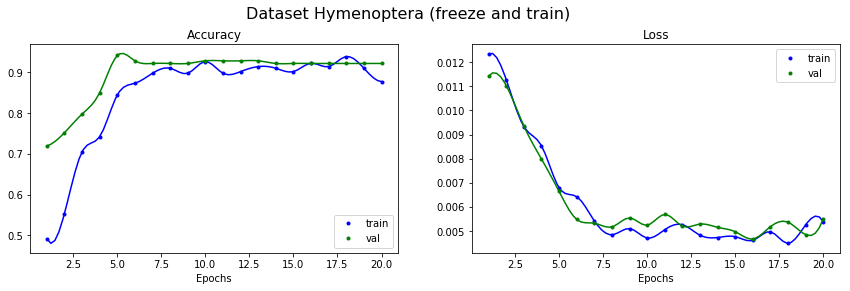

In [28]:
dataset_name = "Dataset Hymenoptera (freeze and train)"
plot_metrics(metrics, dataset_name)
df.at[dataset_name, val_acc] = max(metrics['val_acc'])

In [29]:
model, metrics = finetune(data_hymenoptera_gray, MODEL_NAME, SETS, EPOCHS, 1, LR, 
                          MOMENTUM, LR_STEP, LR_EPOCHS)


Epoch 1/20
----------
train Loss: 0.0119 Acc: 0.4672
val Loss: 0.0135 Acc: 0.6078

Epoch 2/20
----------
train Loss: 0.0107 Acc: 0.5984
val Loss: 0.0117 Acc: 0.7386

Epoch 3/20
----------
train Loss: 0.0088 Acc: 0.7910
val Loss: 0.0093 Acc: 0.7908

Epoch 4/20
----------
train Loss: 0.0073 Acc: 0.8484
val Loss: 0.0076 Acc: 0.8627

Epoch 5/20
----------
train Loss: 0.0067 Acc: 0.8648
val Loss: 0.0066 Acc: 0.8758

Epoch 6/20
----------
train Loss: 0.0051 Acc: 0.8893
val Loss: 0.0051 Acc: 0.9020

Epoch 7/20
----------
train Loss: 0.0051 Acc: 0.8730
val Loss: 0.0049 Acc: 0.9020

Epoch 8/20
----------
train Loss: 0.0044 Acc: 0.9221
val Loss: 0.0054 Acc: 0.9020

Epoch 9/20
----------
train Loss: 0.0044 Acc: 0.9016
val Loss: 0.0052 Acc: 0.9150

Epoch 10/20
----------
train Loss: 0.0046 Acc: 0.9057
val Loss: 0.0049 Acc: 0.9150

Epoch 11/20
----------
train Loss: 0.0040 Acc: 0.9303
val Loss: 0.0053 Acc: 0.9150

Epoch 12/20
----------
train Loss: 0.0042 Acc: 0.9303
val Loss: 0.0049 Acc: 0.9085



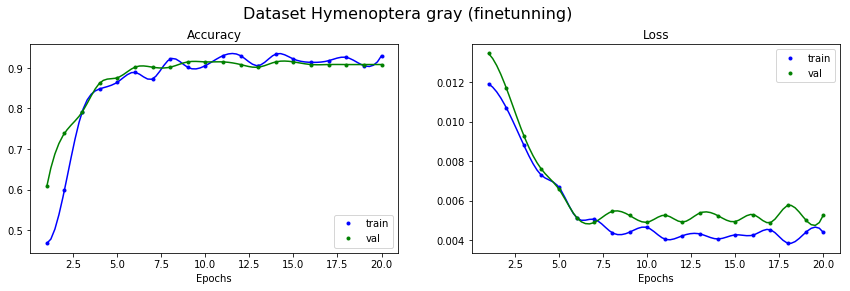

In [30]:
dataset_name = "Dataset Hymenoptera gray (finetuning)"
plot_metrics(metrics, dataset_name)
df.at[dataset_name, val_acc] = max(metrics['val_acc'])

In [31]:
model, metrics = freeze_and_train(data_hymenoptera_gray, MODEL_NAME, SETS, EPOCHS, 1, LR, 
                                  MOMENTUM, LR_STEP, LR_EPOCHS)


Epoch 1/20
----------
train Loss: 0.0113 Acc: 0.5492
val Loss: 0.0134 Acc: 0.5752

Epoch 2/20
----------
train Loss: 0.0106 Acc: 0.6311
val Loss: 0.0124 Acc: 0.6275

Epoch 3/20
----------
train Loss: 0.0103 Acc: 0.6598
val Loss: 0.0111 Acc: 0.6797

Epoch 4/20
----------
train Loss: 0.0090 Acc: 0.7459
val Loss: 0.0111 Acc: 0.7059

Epoch 5/20
----------
train Loss: 0.0082 Acc: 0.7705
val Loss: 0.0092 Acc: 0.8039

Epoch 6/20
----------
train Loss: 0.0073 Acc: 0.8156
val Loss: 0.0090 Acc: 0.8170

Epoch 7/20
----------
train Loss: 0.0069 Acc: 0.8402
val Loss: 0.0074 Acc: 0.8627

Epoch 8/20
----------
train Loss: 0.0064 Acc: 0.8443
val Loss: 0.0079 Acc: 0.8562

Epoch 9/20
----------
train Loss: 0.0063 Acc: 0.8811
val Loss: 0.0077 Acc: 0.8627

Epoch 10/20
----------
train Loss: 0.0063 Acc: 0.8730
val Loss: 0.0072 Acc: 0.8889

Epoch 11/20
----------
train Loss: 0.0061 Acc: 0.8770
val Loss: 0.0075 Acc: 0.8889

Epoch 12/20
----------
train Loss: 0.0062 Acc: 0.8730
val Loss: 0.0073 Acc: 0.8758



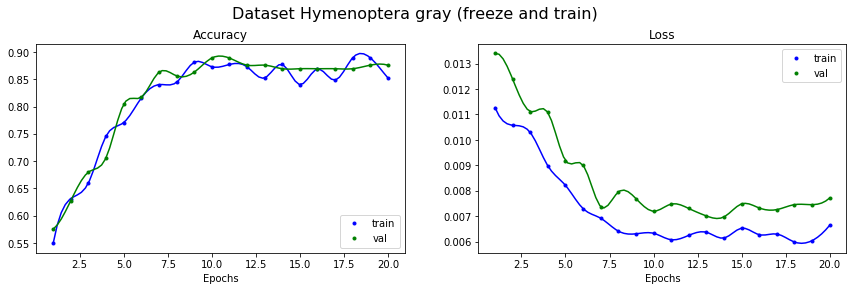

In [32]:
dataset_name = "Dataset Hymenoptera gray (freeze and train)"
plot_metrics(metrics, dataset_name)
df.at[dataset_name, val_acc] = max(metrics['val_acc'])

Transfer learning with Simpsons dataset

In [33]:
model, metrics = finetune(data_simpsons, MODEL_NAME, SETS, EPOCHS, NUM_GPUS, LR, 
                          MOMENTUM, LR_STEP, LR_EPOCHS)


Epoch 1/20
----------
train Loss: 0.0107 Acc: 0.2058
val Loss: 0.0091 Acc: 0.4146

Epoch 2/20
----------
train Loss: 0.0080 Acc: 0.5079
val Loss: 0.0056 Acc: 0.6972

Epoch 3/20
----------
train Loss: 0.0059 Acc: 0.6439
val Loss: 0.0036 Acc: 0.7934

Epoch 4/20
----------
train Loss: 0.0046 Acc: 0.7097
val Loss: 0.0028 Acc: 0.8358

Epoch 5/20
----------
train Loss: 0.0040 Acc: 0.7466
val Loss: 0.0023 Acc: 0.8703

Epoch 6/20
----------
train Loss: 0.0036 Acc: 0.7676
val Loss: 0.0019 Acc: 0.8859

Epoch 7/20
----------
train Loss: 0.0032 Acc: 0.7906
val Loss: 0.0017 Acc: 0.9015

Epoch 8/20
----------
train Loss: 0.0031 Acc: 0.7940
val Loss: 0.0016 Acc: 0.9036

Epoch 9/20
----------
train Loss: 0.0031 Acc: 0.7927
val Loss: 0.0016 Acc: 0.9033

Epoch 10/20
----------
train Loss: 0.0031 Acc: 0.7966
val Loss: 0.0016 Acc: 0.9066

Epoch 11/20
----------
train Loss: 0.0031 Acc: 0.7994
val Loss: 0.0016 Acc: 0.9097

Epoch 12/20
----------
train Loss: 0.0031 Acc: 0.7969
val Loss: 0.0016 Acc: 0.9102



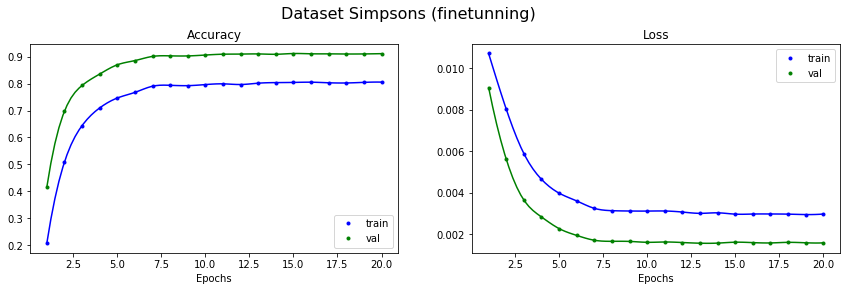

In [34]:
dataset_name = "Dataset Simpsons (finetuning)"
plot_metrics(metrics, dataset_name)
df.at[dataset_name, val_acc] = max(metrics['val_acc'])

In [35]:
model, metrics = freeze_and_train(data_simpsons, MODEL_NAME, SETS, EPOCHS, NUM_GPUS, LR, 
                                  MOMENTUM, LR_STEP, LR_EPOCHS)


Epoch 1/20
----------
train Loss: 0.0113 Acc: 0.1250
val Loss: 0.0109 Acc: 0.2041

Epoch 2/20
----------
train Loss: 0.0102 Acc: 0.2427
val Loss: 0.0098 Acc: 0.3289

Epoch 3/20
----------
train Loss: 0.0094 Acc: 0.3495
val Loss: 0.0089 Acc: 0.4540

Epoch 4/20
----------
train Loss: 0.0088 Acc: 0.4186
val Loss: 0.0082 Acc: 0.5146

Epoch 5/20
----------
train Loss: 0.0083 Acc: 0.4644
val Loss: 0.0077 Acc: 0.5491

Epoch 6/20
----------
train Loss: 0.0079 Acc: 0.4958
val Loss: 0.0073 Acc: 0.5739

Epoch 7/20
----------
train Loss: 0.0076 Acc: 0.5120
val Loss: 0.0069 Acc: 0.5977

Epoch 8/20
----------
train Loss: 0.0074 Acc: 0.5300
val Loss: 0.0069 Acc: 0.5990

Epoch 9/20
----------
train Loss: 0.0074 Acc: 0.5350
val Loss: 0.0068 Acc: 0.5990

Epoch 10/20
----------
train Loss: 0.0073 Acc: 0.5352
val Loss: 0.0068 Acc: 0.6033

Epoch 11/20
----------
train Loss: 0.0073 Acc: 0.5329
val Loss: 0.0068 Acc: 0.5972

Epoch 12/20
----------
train Loss: 0.0073 Acc: 0.5370
val Loss: 0.0068 Acc: 0.5997



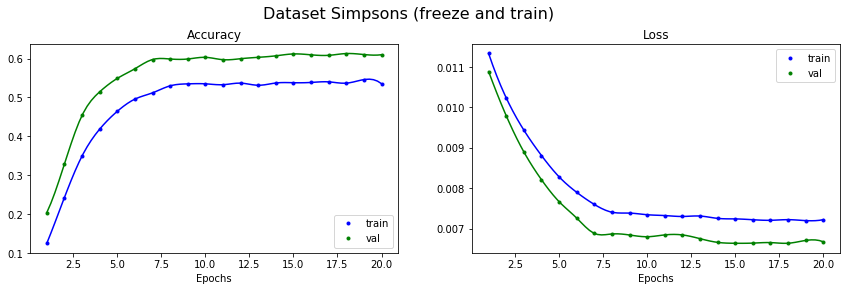

In [36]:
dataset_name = "Dataset Simpsons (freeze and train)"
plot_metrics(metrics, dataset_name)
df.at[dataset_name, val_acc] = max(metrics['val_acc'])

In [37]:
model, metrics = finetune(data_simpsons_gray, MODEL_NAME, SETS, EPOCHS, NUM_GPUS, LR, 
                          MOMENTUM, LR_STEP, LR_EPOCHS)


Epoch 1/20
----------
train Loss: 0.0110 Acc: 0.1544
val Loss: 0.0099 Acc: 0.3033

Epoch 2/20
----------
train Loss: 0.0089 Acc: 0.3945
val Loss: 0.0069 Acc: 0.5737

Epoch 3/20
----------
train Loss: 0.0070 Acc: 0.5555
val Loss: 0.0048 Acc: 0.7197

Epoch 4/20
----------
train Loss: 0.0058 Acc: 0.6275
val Loss: 0.0037 Acc: 0.7895

Epoch 5/20
----------
train Loss: 0.0051 Acc: 0.6705
val Loss: 0.0030 Acc: 0.8207

Epoch 6/20
----------
train Loss: 0.0046 Acc: 0.6967
val Loss: 0.0025 Acc: 0.8402

Epoch 7/20
----------
train Loss: 0.0042 Acc: 0.7146
val Loss: 0.0023 Acc: 0.8563

Epoch 8/20
----------
train Loss: 0.0040 Acc: 0.7277
val Loss: 0.0023 Acc: 0.8598

Epoch 9/20
----------
train Loss: 0.0040 Acc: 0.7307
val Loss: 0.0022 Acc: 0.8652

Epoch 10/20
----------
train Loss: 0.0040 Acc: 0.7328
val Loss: 0.0022 Acc: 0.8632

Epoch 11/20
----------
train Loss: 0.0039 Acc: 0.7351
val Loss: 0.0022 Acc: 0.8650

Epoch 12/20
----------
train Loss: 0.0039 Acc: 0.7320
val Loss: 0.0022 Acc: 0.8688



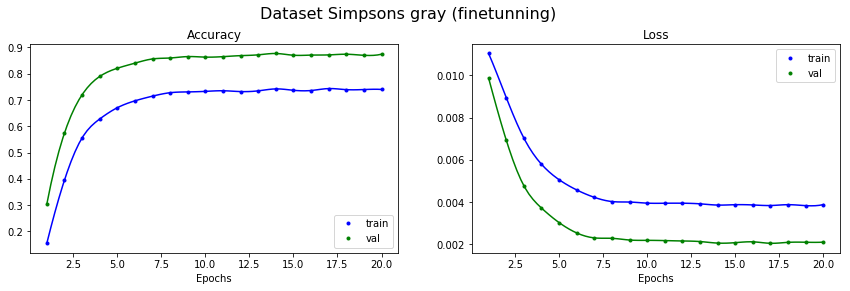

In [38]:
dataset_name = "Dataset Simpsons gray (finetuning)"
plot_metrics(metrics, dataset_name)
df.at[dataset_name, val_acc] = max(metrics['val_acc'])

In [39]:
model, metrics = freeze_and_train(data_simpsons_gray, MODEL_NAME, SETS, EPOCHS, NUM_GPUS, LR, 
                                  MOMENTUM, LR_STEP, LR_EPOCHS)


Epoch 1/20
----------
train Loss: 0.0115 Acc: 0.1032
val Loss: 0.0113 Acc: 0.1581

Epoch 2/20
----------
train Loss: 0.0106 Acc: 0.2003
val Loss: 0.0103 Acc: 0.2724

Epoch 3/20
----------
train Loss: 0.0100 Acc: 0.2771
val Loss: 0.0096 Acc: 0.3621

Epoch 4/20
----------
train Loss: 0.0095 Acc: 0.3322
val Loss: 0.0091 Acc: 0.4161

Epoch 5/20
----------
train Loss: 0.0091 Acc: 0.3711
val Loss: 0.0086 Acc: 0.4348

Epoch 6/20
----------
train Loss: 0.0088 Acc: 0.3921
val Loss: 0.0083 Acc: 0.4506

Epoch 7/20
----------
train Loss: 0.0085 Acc: 0.4142
val Loss: 0.0079 Acc: 0.4877

Epoch 8/20
----------
train Loss: 0.0084 Acc: 0.4266
val Loss: 0.0079 Acc: 0.4859

Epoch 9/20
----------
train Loss: 0.0083 Acc: 0.4244
val Loss: 0.0078 Acc: 0.4934

Epoch 10/20
----------
train Loss: 0.0083 Acc: 0.4273
val Loss: 0.0079 Acc: 0.4944

Epoch 11/20
----------
train Loss: 0.0083 Acc: 0.4293
val Loss: 0.0079 Acc: 0.4811

Epoch 12/20
----------
train Loss: 0.0083 Acc: 0.4353
val Loss: 0.0078 Acc: 0.4957



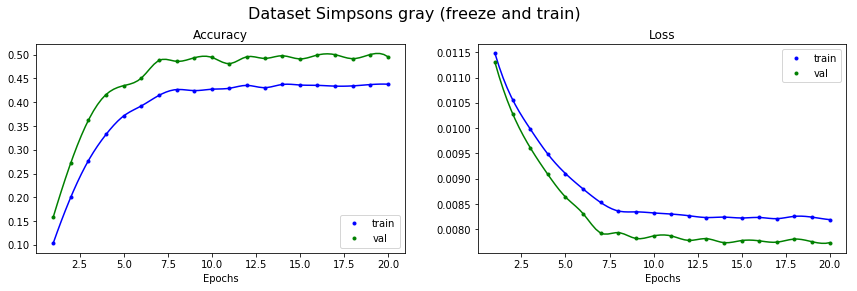

In [40]:
dataset_name = "Dataset Simpsons gray (freeze and train)"
plot_metrics(metrics, dataset_name)
df.at[dataset_name, val_acc] = max(metrics['val_acc'])

Transfer learning with dogs vs cats

In [41]:
model, metrics = finetune(data_dogs_vs_cats, MODEL_NAME, SETS, EPOCHS, NUM_GPUS, LR, 
                          MOMENTUM, LR_STEP, LR_EPOCHS)


Epoch 1/5
----------
train Loss: 0.0010 Acc: 0.8931
val Loss: 0.0002 Acc: 0.9812

Epoch 2/5
----------
train Loss: 0.0005 Acc: 0.9436
val Loss: 0.0002 Acc: 0.9866

Epoch 3/5
----------
train Loss: 0.0005 Acc: 0.9498
val Loss: 0.0001 Acc: 0.9884

Epoch 4/5
----------
train Loss: 0.0004 Acc: 0.9534
val Loss: 0.0001 Acc: 0.9870

Epoch 5/5
----------
train Loss: 0.0004 Acc: 0.9578
val Loss: 0.0001 Acc: 0.9892
Training complete in 4m 6s
Best val Acc: 0.989200


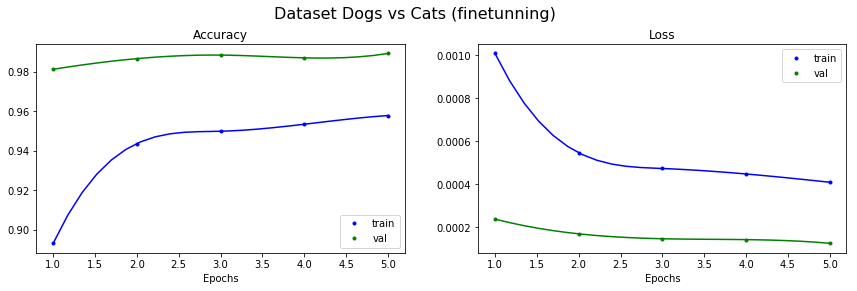

In [42]:
dataset_name = "Dataset Dogs vs Cats (finetuning)"
plot_metrics(metrics, dataset_name)
df.at[dataset_name, val_acc] = max(metrics['val_acc'])

In [43]:
model, metrics = freeze_and_train(data_dogs_vs_cats, MODEL_NAME, SETS, EPOCHS, NUM_GPUS, LR, 
                                  MOMENTUM, LR_STEP, LR_EPOCHS)


Epoch 1/20
----------
train Loss: 0.0012 Acc: 0.8639
val Loss: 0.0004 Acc: 0.9724

Epoch 2/20
----------
train Loss: 0.0007 Acc: 0.9322
val Loss: 0.0003 Acc: 0.9748

Epoch 3/20
----------
train Loss: 0.0007 Acc: 0.9317
val Loss: 0.0003 Acc: 0.9774

Epoch 4/20
----------
train Loss: 0.0006 Acc: 0.9346
val Loss: 0.0003 Acc: 0.9796

Epoch 5/20
----------
train Loss: 0.0006 Acc: 0.9357
val Loss: 0.0002 Acc: 0.9802

Epoch 6/20
----------
train Loss: 0.0006 Acc: 0.9374
val Loss: 0.0002 Acc: 0.9804

Epoch 7/20
----------
train Loss: 0.0006 Acc: 0.9395
val Loss: 0.0002 Acc: 0.9792

Epoch 8/20
----------
train Loss: 0.0006 Acc: 0.9386
val Loss: 0.0002 Acc: 0.9808

Epoch 9/20
----------
train Loss: 0.0006 Acc: 0.9384
val Loss: 0.0002 Acc: 0.9808

Epoch 10/20
----------
train Loss: 0.0006 Acc: 0.9361
val Loss: 0.0002 Acc: 0.9810

Epoch 11/20
----------
train Loss: 0.0006 Acc: 0.9401
val Loss: 0.0002 Acc: 0.9806

Epoch 12/20
----------
train Loss: 0.0006 Acc: 0.9391
val Loss: 0.0002 Acc: 0.9816



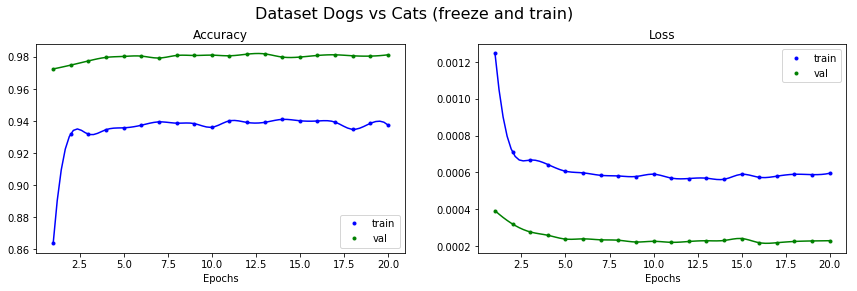

In [44]:
dataset_name = "Dataset Dogs vs Cats (freeze and train)"
plot_metrics(metrics, dataset_name)
df.at[dataset_name, val_acc] = max(metrics['val_acc'])

In [45]:
model, metrics = finetune(data_dogs_vs_cats_gray, MODEL_NAME, SETS, EPOCHS, NUM_GPUS, LR, 
                          MOMENTUM, LR_STEP, LR_EPOCHS)


Epoch 1/20
----------
train Loss: 0.0012 Acc: 0.8643
val Loss: 0.0003 Acc: 0.9746

Epoch 2/20
----------
train Loss: 0.0006 Acc: 0.9352
val Loss: 0.0002 Acc: 0.9798

Epoch 3/20
----------
train Loss: 0.0006 Acc: 0.9411
val Loss: 0.0002 Acc: 0.9840

Epoch 4/20
----------
train Loss: 0.0005 Acc: 0.9463
val Loss: 0.0002 Acc: 0.9840

Epoch 5/20
----------
train Loss: 0.0005 Acc: 0.9486
val Loss: 0.0002 Acc: 0.9850

Epoch 6/20
----------
train Loss: 0.0005 Acc: 0.9498
val Loss: 0.0002 Acc: 0.9848

Epoch 7/20
----------
train Loss: 0.0005 Acc: 0.9510
val Loss: 0.0002 Acc: 0.9850

Epoch 8/20
----------
train Loss: 0.0004 Acc: 0.9517
val Loss: 0.0001 Acc: 0.9860

Epoch 9/20
----------
train Loss: 0.0004 Acc: 0.9549
val Loss: 0.0002 Acc: 0.9842

Epoch 10/20
----------
train Loss: 0.0004 Acc: 0.9533
val Loss: 0.0001 Acc: 0.9858

Epoch 11/20
----------
train Loss: 0.0004 Acc: 0.9548
val Loss: 0.0001 Acc: 0.9858

Epoch 12/20
----------
train Loss: 0.0004 Acc: 0.9542
val Loss: 0.0002 Acc: 0.9856



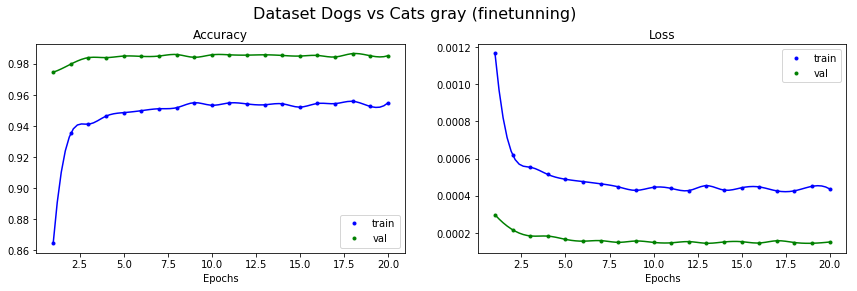

In [46]:
dataset_name = "Dataset Dogs vs Cats gray (finetuning)"
plot_metrics(metrics, dataset_name)
df.at[dataset_name, val_acc] = max(metrics['val_acc'])

In [47]:
model, metrics = freeze_and_train(data_dogs_vs_cats_gray, MODEL_NAME, SETS, EPOCHS, NUM_GPUS, LR, 
                                  MOMENTUM, LR_STEP, LR_EPOCHS)


Epoch 1/20
----------
train Loss: 0.0014 Acc: 0.8494
val Loss: 0.0005 Acc: 0.9626

Epoch 2/20
----------
train Loss: 0.0009 Acc: 0.9074
val Loss: 0.0004 Acc: 0.9640

Epoch 3/20
----------
train Loss: 0.0008 Acc: 0.9136
val Loss: 0.0004 Acc: 0.9698

Epoch 4/20
----------
train Loss: 0.0008 Acc: 0.9196
val Loss: 0.0003 Acc: 0.9702

Epoch 5/20
----------
train Loss: 0.0007 Acc: 0.9215
val Loss: 0.0003 Acc: 0.9710

Epoch 6/20
----------
train Loss: 0.0007 Acc: 0.9216
val Loss: 0.0003 Acc: 0.9718

Epoch 7/20
----------
train Loss: 0.0007 Acc: 0.9244
val Loss: 0.0003 Acc: 0.9738

Epoch 8/20
----------
train Loss: 0.0007 Acc: 0.9228
val Loss: 0.0003 Acc: 0.9730

Epoch 9/20
----------
train Loss: 0.0007 Acc: 0.9237
val Loss: 0.0003 Acc: 0.9728

Epoch 10/20
----------
train Loss: 0.0007 Acc: 0.9226
val Loss: 0.0003 Acc: 0.9710

Epoch 11/20
----------
train Loss: 0.0007 Acc: 0.9252
val Loss: 0.0003 Acc: 0.9726

Epoch 12/20
----------
train Loss: 0.0007 Acc: 0.9226
val Loss: 0.0003 Acc: 0.9740



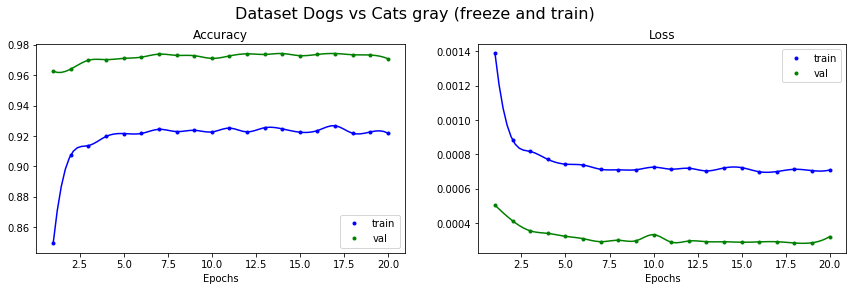

In [ ]:
dataset_name = "Dataset Dogs vs Cats gray (freeze and train)"
plot_metrics(metrics, dataset_name)
df.at[dataset_name, val_acc] = max(metrics['val_acc'])

In [ ]:
model, metrics = finetune(data_caltech256, MODEL_NAME, SETS, EPOCHS, NUM_GPUS, LR, 
                          MOMENTUM, LR_STEP, LR_EPOCHS)


Epoch 1/20
----------
train Loss: 0.0211 Acc: 0.0592
val Loss: 0.0195 Acc: 0.1060

Epoch 2/20
----------
train Loss: 0.0187 Acc: 0.1307
val Loss: 0.0176 Acc: 0.1764

Epoch 3/20
----------
train Loss: 0.0170 Acc: 0.1929
val Loss: 0.0157 Acc: 0.2601

Epoch 4/20
----------
train Loss: 0.0155 Acc: 0.2587
val Loss: 0.0140 Acc: 0.3327

Epoch 5/20
----------
train Loss: 0.0141 Acc: 0.3168
val Loss: 0.0126 Acc: 0.4060

Epoch 6/20
----------
train Loss: 0.0130 Acc: 0.3708
val Loss: 0.0114 Acc: 0.4537

Epoch 7/20
----------
train Loss: 0.0120 Acc: 0.4174
val Loss: 0.0104 Acc: 0.5031

Epoch 8/20
----------
train Loss: 0.0115 Acc: 0.4438
val Loss: 0.0103 Acc: 0.5098

Epoch 9/20
----------
train Loss: 0.0114 Acc: 0.4504
val Loss: 0.0102 Acc: 0.5146

Epoch 10/20
----------
train Loss: 0.0113 Acc: 0.4490
val Loss: 0.0101 Acc: 0.5201

Epoch 11/20
----------
train Loss: 0.0112 Acc: 0.4547
val Loss: 0.0100 Acc: 0.5186

Epoch 12/20
----------
train Loss: 0.0111 Acc: 0.4624
val Loss: 0.0100 Acc: 0.5242



In [50]:
dataset_name = "Dataset Caltech256 (finetuning)"
plot_metrics(metrics, dataset_name)
df.at[dataset_name, val_acc] = max(metrics['val_acc'])

In [51]:
model, metrics = freeze_and_train(data_caltech256, MODEL_NAME, SETS, EPOCHS, NUM_GPUS, LR, 
                                  MOMENTUM, LR_STEP, LR_EPOCHS)

train Loss: 0.0216 Acc: 0.0387
val Loss: 0.0209 Acc: 0.0420

Epoch 2/20
----------
train Loss: 0.0200 Acc: 0.0864
val Loss: 0.0199 Acc: 0.0654

Epoch 3/20
----------
train Loss: 0.0190 Acc: 0.1194
val Loss: 0.0191 Acc: 0.0984

Epoch 4/20
----------
train Loss: 0.0181 Acc: 0.1536
val Loss: 0.0183 Acc: 0.1339

Epoch 5/20
----------
train Loss: 0.0173 Acc: 0.1854
val Loss: 0.0177 Acc: 0.1664

Epoch 6/20
----------
train Loss: 0.0166 Acc: 0.2180
val Loss: 0.0171 Acc: 0.2083

Epoch 7/20
----------
train Loss: 0.0159 Acc: 0.2502
val Loss: 0.0165 Acc: 0.2413

Epoch 8/20
----------
train Loss: 0.0156 Acc: 0.2665
val Loss: 0.0165 Acc: 0.2461

Epoch 9/20
----------
train Loss: 0.0155 Acc: 0.2712
val Loss: 0.0164 Acc: 0.2487

Epoch 10/20
----------
train Loss: 0.0155 Acc: 0.2728
val Loss: 0.0164 Acc: 0.2511

Epoch 11/20
----------
train Loss: 0.0154 Acc: 0.2764
val Loss: 0.0163 Acc: 0.2538

Epoch 12/20
----------
train Loss: 0.0154 Acc: 0.2826
val Loss: 0.0162 Acc: 0.2565

Epoch 13/20
----------


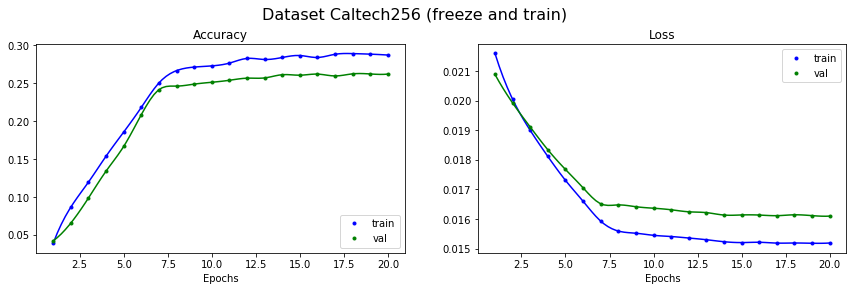

In [52]:
dataset_name = "Dataset Caltech256 (freeze and train)"
plot_metrics(metrics, dataset_name)
df.at[dataset_name, val_acc] = max(metrics['val_acc'])

In [53]:
model, metrics = finetune(data_caltech256_gray, MODEL_NAME, SETS, EPOCHS, NUM_GPUS, LR, 
                          MOMENTUM, LR_STEP, LR_EPOCHS)


Epoch 1/20
----------
train Loss: 0.0210 Acc: 0.0580
val Loss: 0.0197 Acc: 0.0842

Epoch 2/20
----------
train Loss: 0.0186 Acc: 0.1338
val Loss: 0.0176 Acc: 0.1787

Epoch 3/20
----------
train Loss: 0.0169 Acc: 0.1971
val Loss: 0.0158 Acc: 0.2606

Epoch 4/20
----------
train Loss: 0.0153 Acc: 0.2607
val Loss: 0.0141 Acc: 0.3371

Epoch 5/20
----------
train Loss: 0.0140 Acc: 0.3238
val Loss: 0.0127 Acc: 0.3983

Epoch 6/20
----------
train Loss: 0.0128 Acc: 0.3802
train Loss: 0.0113 Acc: 0.4547
val Loss: 0.0103 Acc: 0.5016

Epoch 10/20
----------
train Loss: 0.0112 Acc: 0.4593
val Loss: 0.0103 Acc: 0.5062

Epoch 11/20
----------
train Loss: 0.0112 Acc: 0.4625
val Loss: 0.0102 Acc: 0.5098

Epoch 12/20
----------
train Loss: 0.0111 Acc: 0.4678
val Loss: 0.0101 Acc: 0.5118

Epoch 13/20
----------
train Loss: 0.0110 Acc: 0.4725
val Loss: 0.0101 Acc: 0.5154

Epoch 14/20
----------
train Loss: 0.0109 Acc: 0.4679
val Loss: 0.0100 Acc: 0.5177

Epoch 15/20
----------
train Loss: 0.0109 Acc: 0.4

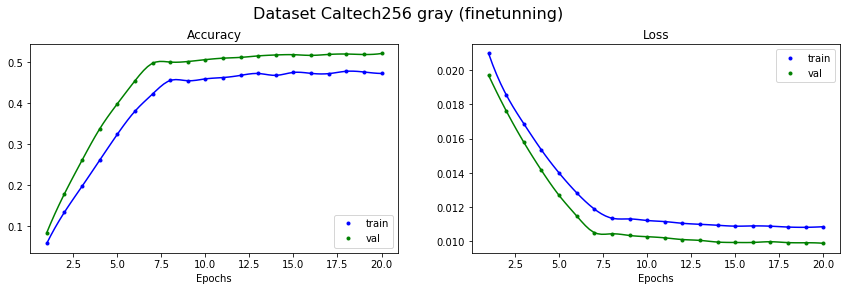

In [54]:
dataset_name = "Dataset Caltech256 gray (finetuning)"
plot_metrics(metrics, dataset_name)
df.at[dataset_name, val_acc] = max(metrics['val_acc'])

In [55]:
model, metrics = freeze_and_train(data_caltech256_gray, MODEL_NAME, SETS, EPOCHS, NUM_GPUS, LR, 
                                  MOMENTUM, LR_STEP, LR_EPOCHS)


Epoch 1/20
----------
train Loss: 0.0215 Acc: 0.0483
val Loss: 0.0210 Acc: 0.0558

Epoch 2/20
----------
train Loss: 0.0200 Acc: 0.0956
val Loss: 0.0200 Acc: 0.0788

Epoch 3/20
----------
train Loss: 0.0190 Acc: 0.1250
val Loss: 0.0192 Acc: 0.1076

Epoch 4/20
----------
train Loss: 0.0181 Acc: 0.1548
val Loss: 0.0185 Acc: 0.1359

Epoch 5/20
----------
train Loss: 0.0173 Acc: 0.1829
val Loss: 0.0178 Acc: 0.1705

Epoch 6/20
----------
train Loss: 0.0166 Acc: 0.2146
val Loss: 0.0172 Acc: 0.1995

Epoch 7/20
----------
train Loss: 0.0160 Acc: 0.2431
val Loss: 0.0167 Acc: 0.2309

Epoch 8/20
----------
train Loss: 0.0156 Acc: 0.2635
val Loss: 0.0166 Acc: 0.2338

Epoch 9/20
----------
train Loss: 0.0155 Acc: 0.2657
val Loss: 0.0165 Acc: 0.2390

Epoch 10/20
----------
train Loss: 0.0155 Acc: 0.2695
val Loss: 0.0165 Acc: 0.2417

Epoch 11/20
----------
train Loss: 0.0154 Acc: 0.2732
val Loss: 0.0164 Acc: 0.2417

Epoch 12/20
----------
train Loss: 0.0154 Acc: 0.2754
val Loss: 0.0164 Acc: 0.2453



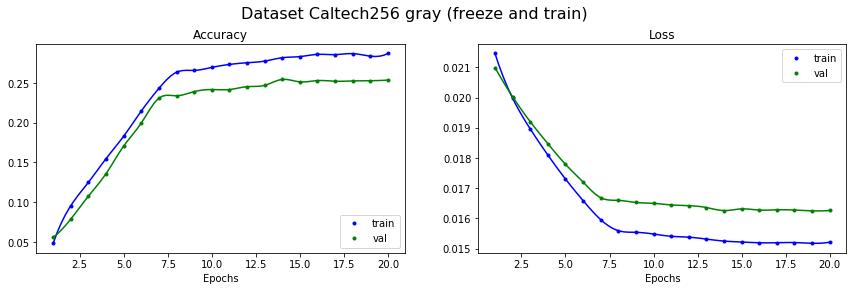

In [56]:
dataset_name = "Dataset Caltech256 gray (freeze and train)"
plot_metrics(metrics, dataset_name)
df.at[dataset_name, val_acc] = max(metrics['val_acc'])

In [57]:
df

,Validation accuracy
Dataset Hymenoptera (finetunning),0.928105
Dataset Hymenoptera (freeze and train),0.941176
Dataset Hymenoptera gray (finetunning),0.915033
Dataset Hymenoptera gray (freeze and train),0.888889
Dataset Simpsons (finetunning),0.912276
Dataset Simpsons (freeze and train),0.613043
Dataset Simpsons gray (finetunning),0.876982
Dataset Simpsons gray (freeze and train),0.500256
Dataset Dogs vs Cats (finetunning),0.9892
Dataset Dogs vs Cats (freeze and train),0.9818
